In [31]:
!pip install qutip

In [2]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [3]:
from scipy.interpolate import interp1d
from scipy.integrate import odeint

In [4]:

#Defining the shape of the output pulse as a function of time
def v(t,args=None):
  #return np.sqrt(gamma)*np.exp(-t*gamma/2)
  return 0

#Defining |v(t)|^2 
def v_2(t):
  return np.conj(v(t))*v(t)

#Defining the time dependent coupling
def g(t, args):
  integral = quad(v_2, 0, t)[0]
  if integral == 0:
    return 0
  else:
    return -np.conj(v(t))/ ( integral**0.5 )


In [196]:
##    Defining All operators    ##

#Number of fock states in the output cavity
N = 2   

#Coupling constant         
gamma = 2

#Defining time of simulation
t = 500                                                                         #temporal resolution/ number of points taken
t_final = 5
times = np.linspace(0.000001, t_final, t)


#Defining initial state of the system and cavity, with the system in excited state 
psi0 = qutip.tensor(qutip.fock(2,1), qutip.fock(N, 0))

#Anihilation operator of the cavity
a  = qutip.tensor(qutip.qeye(2), qutip.destroy(N))

#Lowering operator of the system
c = qutip.tensor(qutip.destroy(2), qutip.qeye(N))

Hs = a.dag()*a                                                                  #system hamiltonian
H = [ [ 0.5j*(gamma**0.5)*( (c.dag()*a)-(a.dag()*c) ) , g]]                     #Net time dependent Hamiltonian (Eq 5 in the Quantum Pulses paper)

L_0 = [ (gamma**0.5)*c, [a, g] ]                                                #Lindblad operator 0 (Eq 6)

I = qutip.tensor(qutip.qeye(2), qutip.qeye(N))

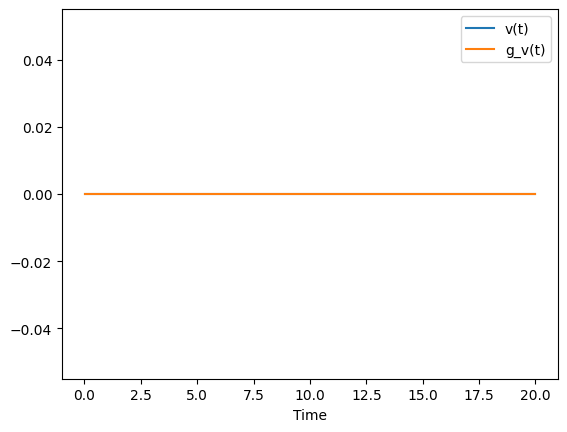

In [6]:
#Plotting out the output pulse and time dependent coupling
plt.plot(times, [v(t) for t in times]) 
plt.plot(times, [g(t, None) for t in times]) 
plt.xlabel('Time') 
plt.legend(("v(t)", "g_v(t)")) 

In [7]:
result = qutip.mesolve(H, psi0, times, [L_0,], [c.dag()*c, a.dag()*a])          #Evolving the system , with output c*c and a*a

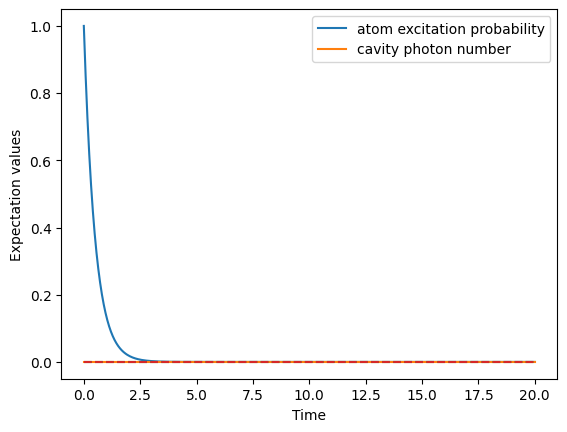

2

In [8]:
plt.figure() 
plt.plot(times, result.expect[0]) 
plt.plot(times, result.expect[1]) 
plt.xlabel('Time') 
plt.ylabel('Expectation values') 
plt.legend(("atom excitation probability", "cavity photon number")) 
plt.plot([times[0], times[-1]], [result.expect[0][-1], result.expect[0][-1]],'--')
plt.plot([times[0], times[-1]], [result.expect[1][-1], result.expect[1][-1]],'--')
plt.show() 
gamma

---
---
# Calculating ideal $v(t)$ using correlation funtion:

In [197]:
times_2 = np.linspace(0, t_final, t)
#make syre to set v(t), ie all coupling to zero for this
correlation = qutip.correlation_2op_2t(H, psi0, times_2, times_2, [L_0,], (gamma**0.5)*c.dag(), (gamma**0.5)*c)

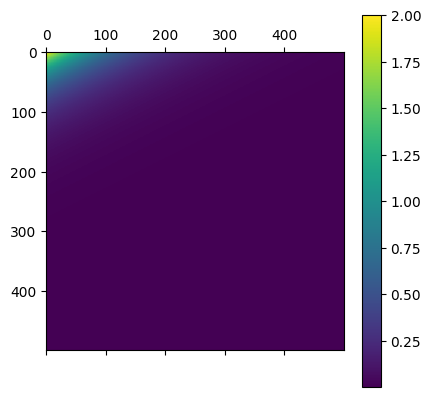

In [198]:
plt.matshow(np.real(correlation))
plt.colorbar()
#plotting v(t) vs v(t+tau)

In [199]:
delta_t = times[1]

In [200]:
tdash_corel = np.zeros_like(correlation)

for i in range(t):
    tdash_corel[i][i:] = correlation[i][:(t-i)]

tdash_corel = tdash_corel + tdash_corel.T - (tdash_corel*np.eye(t))
#tdash_corel = tdash_corel/(np.trace(tdash_corel)* delta_t)


n, func = np.linalg.eig(tdash_corel)
#n_, func_ = np.linalg.eig(tdash_corel/np.sum(n))
n = n/np.sum(n)
func_ = func/np.sqrt(delta_t)


In [201]:
np.trace(tdash_corel)* delta_t

(1.010111644491204+0j)

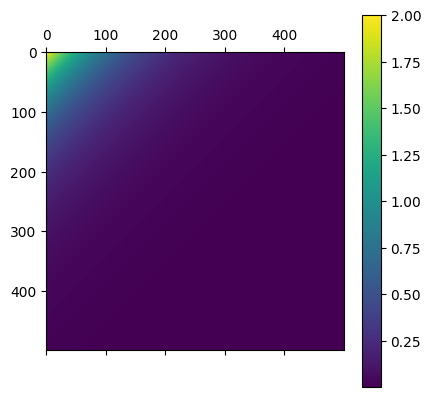

In [202]:
plt.matshow(np.real(tdash_corel))
plt.colorbar()

In [203]:
no_cav = 4
v_funct = dict()
alpha_funct = dict()
g_funct = dict()

# cavno_influenced by which cav no

for i in range(no_cav):
    v_funct[i,-1] = interp1d(times, np.real(func_[:,i]), fill_value='extrapolate')

def da_vi_j(alpha, t ,i ,j ):
    da_vi_j = -(g_funct[j](t) * v_funct[i,j-1](t)) - (0.5*alpha*(g_funct[j](t))**2)
    return np.float32(da_vi_j)

def g_cnstr(v_list):
    return np.real(-v_list/(delta_t*np.cumsum(v_list**2))**0.5)

g_funct[0] = qutip.interpolate.Cubic_Spline(times[0], times[-1], g_cnstr(v_funct[0,-1](times)))

In [204]:
for i in range(1, no_cav):
    #cavity no
    for j in range(i):
        #cavity no i, influenced by cavity j

        # generate alpha[i,j]
        alpha_list = odeint(da_vi_j,0,times,args=(i,j))[:,0]
        alpha_funct[i,j] = interp1d(times, alpha_list, fill_value='extrapolate')

        #generate v[i,j]
        v_funct[i,j] = interp1d(times, (v_funct[i,j-1](times) + (g_funct[j](times) * alpha_funct[i,j](times))), fill_value='extrapolate')

        # till j = i-1
        # generate g[i]
    #S = qutip.interpolate.Cubic_Spline(times[0], times[-1], g_cnstr(v_funct[i,i-1](times))
    #g_funct[i] = interp1d(times, g_cnstr(v_funct[i,i-1](times)), fill_value='extrapolate')
    g_funct[i] = qutip.interpolate.Cubic_Spline(times[0], times[-1], g_cnstr(v_funct[i,i-1](times)))
            

In [205]:
g_0 = qutip.interpolate.Cubic_Spline(times[0], times[-1], g_cnstr(v_funct[0,-1](times)))

In [206]:
g_funct[3]

In [207]:
for i in range(no_cav):
    print(times[1]*np.sum(func_[:,i]**2))

(0.999999999999998+0j)
(0.9999999999999978+0j)
(1.0000000000000002+0j)
(0.9999999999999996+0j)


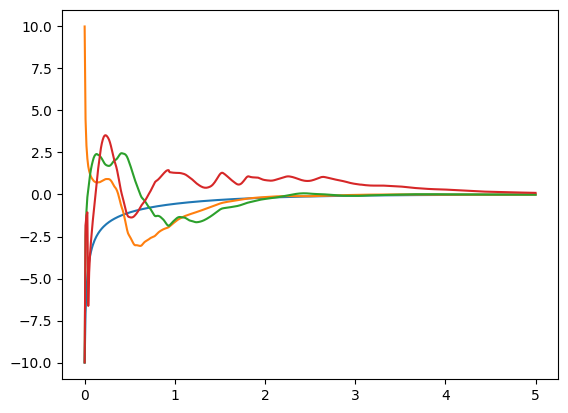

In [208]:
for i in range(no_cav):
    plt.plot(times, g_funct[i](times))

In [209]:
g_list = [g_0, 8, 9]

In [210]:
g_list[0](5)

-0.009481328212937479

In [221]:
N = 2   

#Coupling constant         
gamma = 2

#Defining initial state of the system and cavity, with the system in excited state 
psi0 = qutip.tensor(qutip.fock(2,1), qutip.fock(N, 0))

#Anihilation operator of the cavity
a  = qutip.tensor(qutip.qeye(2), qutip.destroy(N))

#Lowering operator of the system
c = qutip.tensor(qutip.destroy(2), qutip.qeye(N))

Hs = a.dag()*a                                                                  #system hamiltonian
H = [ [ 0.5j*(gamma**0.5)*( (c.dag()*a)-(a.dag()*c) ) , g_funct[0]]]                     #Net time dependent Hamiltonian (Eq 5 in the Quantum Pulses paper)

L_0 = [ (gamma**0.5)*c, [a, g_funct[0]] ]                                                #Lindblad operator 0 (Eq 6)

I = qutip.tensor(qutip.qeye(2), qutip.qeye(N))

In [222]:
H.append(a+a.dag())

In [223]:
result = qutip.mesolve(H, psi0, times, [L_0,], [c.dag()*c, a.dag()*a], args = None)  

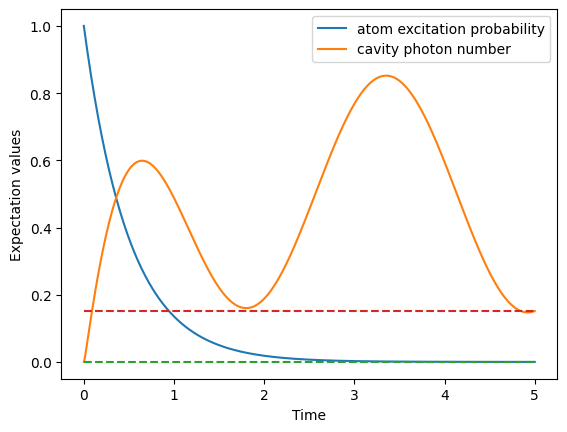

In [224]:
plt.figure() 
plt.plot(times, result.expect[0]) 
plt.plot(times, result.expect[1]) 
plt.xlabel('Time') 
plt.ylabel('Expectation values') 
plt.legend(("atom excitation probability", "cavity photon number")) 
plt.plot([times[0], times[-1]], [result.expect[0][-1], result.expect[0][-1]],'--')
plt.plot([times[0], times[-1]], [result.expect[1][-1], result.expect[1][-1]],'--')
plt.show() 

In [214]:
result.expect[1][-1]

0.9812662494614336

In [181]:
result.expect[1][-1]

0.9904157783266655